In [11]:
from google.colab import drive
drive.mount('/content/drive/')


Mounted at /content/drive/


In [17]:
!cd drive


In [21]:
!ls -R drive/MyDrive


drive/:
MyDrive

drive/MyDrive:
Aleman	Colab_Notebooks  Pdfs  personal

drive/MyDrive/Aleman:
'SCHRITTE 1 CD2-3.rar'	'SCHRITTE 1 GLOSSAR.pdf'		   'SCHRITTE 1 LEHRERHANDBUCH.pdf'
'SCHRITTE 1 CD3-3.rar'	'SCHRITTE 1 KURSBUCH UND ARBEITSBUCH.pdf'

drive/MyDrive/Colab_Notebooks:
Dataset  Model	Untitled0.ipynb  Untitled1.ipynb

drive/MyDrive/Colab_Notebooks/Dataset:
COVID19_ALL.h5ad.tar.gz

drive/MyDrive/Colab_Notebooks/Model:
scFoundation

drive/MyDrive/Colab_Notebooks/Model/scFoundation:
ablation    DeepCDR	 genemodule  model			    preprocessing
annotation  enhancement  LICENSE     MODEL_LICENSE		    README.md
apiexample  GEARS	 mapping     OS_scRNA_gene_index.19264.tsv  SCAD

drive/MyDrive/Colab_Notebooks/Model/scFoundation/ablation:
ablation-00.ipynb  ablation-01.ipynb  ablation-02.ipynb  README.md

drive/MyDrive/Colab_Notebooks/Model/scFoundation/annotation:
annotation_data.zip  celltype-plot.ipynb  README.md

drive/MyDrive/Colab_Notebooks/Model/scFoundation/apiexample:
client.py  data 

In [22]:
!unzip drive/MyDrive/Colab_Notebooks/Model/scFoundation/annotation/annotation_data.zip


Archive:  drive/MyDrive/Colab_Notebooks/Model/scFoundation/annotation/annotation_data.zip
  inflating: data/Segerstolpe-str_label.npy  
  inflating: data/Segerstolpe-test-label.npy  
  inflating: data/celltypist_0806_seg.h5ad  
  inflating: data/celltypist_0806_zheng68k.h5ad  
  inflating: data/seg-cellemb.pkl    
  inflating: data/seg-emb.pkl        
  inflating: data/zheng-cellemb-2mlp.pkl  
  inflating: data/zheng-emb-2mlp.pkl  
  inflating: data/zheng-str_label.npy  
  inflating: data/zheng-test-label.npy  


In [24]:
%pylab inline
!pip install scanpy
import scanpy as sc
import pandas as pd
import pickle

Populating the interactive namespace from numpy and matplotlib
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 22.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.8 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1


In [25]:
seg_label = np.load('./data/Segerstolpe-test-label.npy')
seg_name = np.load('./data/Segerstolpe-str_label.npy')

In [26]:
emb_path="./data/seg-emb.pkl"
emb=None
label=None
f=open(emb_path, 'rb')
while 1:
    try:
        sub_pkl = pickle.load(f)
        tmp_emb = sub_pkl["emb"]
        tmp_label = sub_pkl["label"]
        if emb is None:
            emb = tmp_emb
            label = tmp_label
        else:
            emb = np.vstack([emb,tmp_emb])
            label = np.concatenate([label,tmp_label])
    except:
        break

emb = emb[-seg_label.shape[0]:,:]
label = label[-seg_label.shape[0]:]

In [27]:
emb_path="./data/seg-cellemb.pkl"
cellemb=None
label=None
f=open(emb_path, 'rb')
while 1:
    try:
        sub_pkl = pickle.load(f)
        tmp_emb = sub_pkl["emb"]
        tmp_label = sub_pkl["label"]
        if cellemb is None:
            cellemb = tmp_emb
            label = tmp_label
        else:
            cellemb = np.vstack([cellemb,tmp_emb])
            label = np.concatenate([label,tmp_label])
    except:
        break

cellemb = cellemb[-seg_label.shape[0]:,:]
label = label[-seg_label.shape[0]:]
for i in range(seg_label.shape[0]):
    assert seg_label[i]==label[i]
y_pred = np.argmax(emb,1)


In [28]:
segadata = sc.AnnData(cellemb)
sc.pp.neighbors(segadata,use_rep='X')

sc.tl.umap(segadata)

segadata.obs['true_label']=seg_name[seg_label]
segadata.obs['pred_label']=seg_name[y_pred]

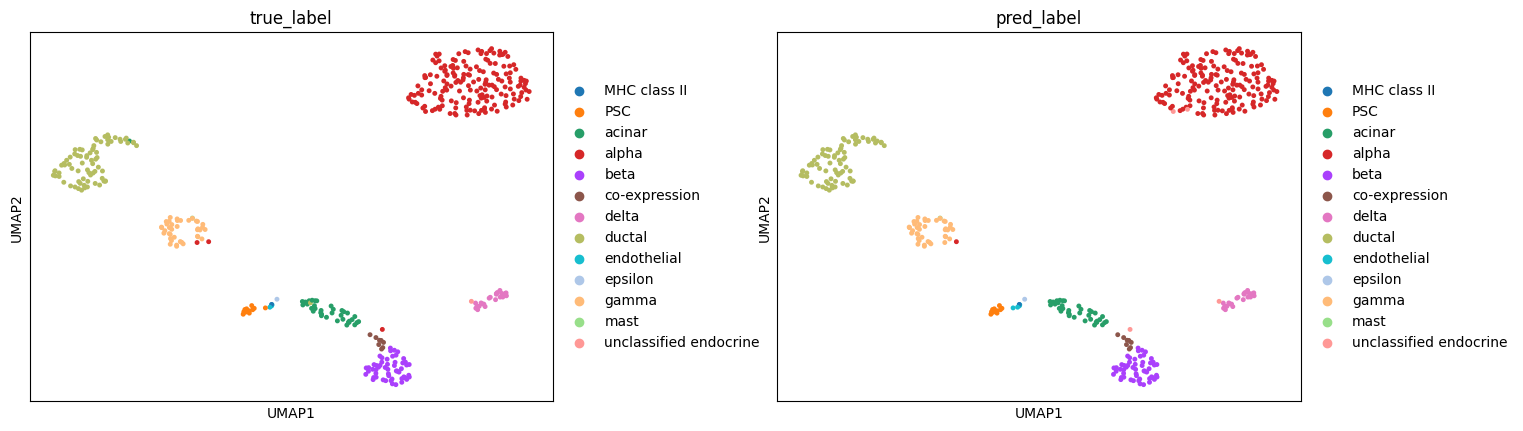

In [29]:
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
sc.pl.umap(segadata,color=['true_label','pred_label'],wspace=0.3,size=50,save='scf_seg')

In [30]:
ctpadata = sc.read_h5ad('./data/celltypist_0806_seg.h5ad')

ctpadata.obs['predict_strlabels']=seg_name[ctpadata.obs['predicted_labels'].values]
ctpadata.obs['predict_strlabels'] = ctpadata.obs['predict_strlabels'].astype('category')

sc.tl.umap(ctpadata)

In [31]:
pal = {}
for i in range(len(seg_name)):
    pal[segadata.obs.true_label.cat.categories[i]]=segadata.uns['true_label_colors'][i]

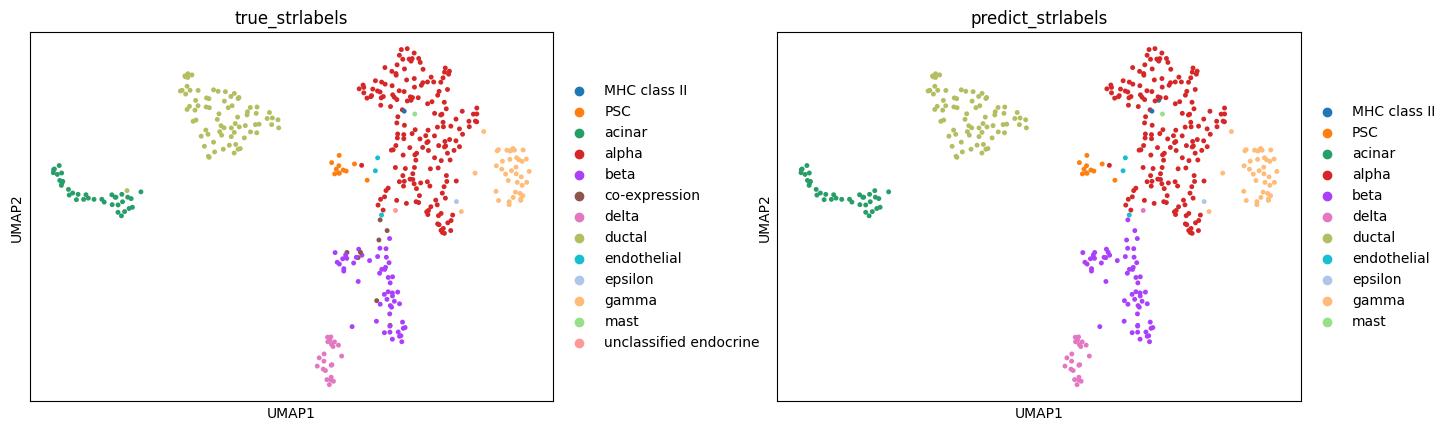

In [32]:
sc.pl.umap(ctpadata,color=['true_strlabels','predict_strlabels'],wspace=0.3,size=50,palette=pal,save='celltypist_seg')


In [ ]:
!python --version

Python 3.11.11


In [ ]:
!apt-get update -y
!apt-get install python3.8 python3.8-distutils
!update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.10
!update-alternatives --config python3
!apt-get install python3-pip
!python3 -m pip install --upgrade pip --user

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:5 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:6 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:8 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:9 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:10 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [ ]:
!python --version


Python 3.10.12


In [ ]:
import sys
if "google.colab" in sys.modules:
    !pip install -U scgpt
    !pip install -q -U gdown
    !pip install -U scanpy

In [ ]:
import os
import gdown
import scanpy as sc
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
data_directory = '/content/drive/MyDrive/biomedicine/data'
model_directory = '/content/drive/MyDrive/biomedicine/model'

In [ ]:
if not os.path.exists(data_directory):
    os.mkdir(data_directory)
if not os.path.exists(model_directory):
    os.mkdir(model_directory)
if not os.path.exists(os.path.join(data_directory, 'GSE158055_covid19_counts.mtx')):
    !wget -c -P $data_directory "https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE158055&format=file&file=GSE158055_covid19_counts.mtx.gz"
    !gunzip $data_directory/GSE158055_covid19_counts.mtx.gz
if not os.path.exists(os.path.join(model_directory, 'best_model.pt')):
    gdown.download_folder(
        "https://drive.google.com/drive/folders/1oWh_-ZRdhtoGQ2Fw24HP41FgLoomVo-y",
        output=model_directory,
    )

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive
